_author: Dana Chermesh Reshef, Director of Urban Data DRAW Brooklyn, June 2019_

# IBZ analysis
The goal of this analysis is to get an undersatnding of different lots in NYC that are under ["Industrial Business Zone" (IBZ)](https://www.nycedc.com/industry/industrial/nyc-industrial-business-zones) designation. Industrial Business Zones (IBZs) were established to protect existing manufacturing districts and encourage industrial growth citywide. 

_Background <br>
In early 2006, the City created sixteen Industrial Business Zones across the City where expanded business services are available for industrial and manufacturing businesses. This designation fosters high-performing business districts by creating competitive advantages over locating in areas outside of New York City. The IBZs are supported by tax credits for relocating within them, zone-specific planning efforts, and direct business assistance from Industrial Providers of NYC Business Solutions Industrial and Transportation. In light of the purpose of IBZs to foster industrial sector growth by creating real estate certainty, the previous administration stated that it would not support the rezoning of these areas for residential use._

See maps of the twenty-one IBZs on the [Ratified IBZs pdf](https://www.nycedc.com/sites/default/files/filemanager/All_Ratified_IBZs_Fall_2013.pdf). 

## 0. Imports

In [1]:
import requests
import pandas as pd
import numpy as np

from __future__ import print_function, division
import matplotlib.pylab as pl
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
sns.set_style('whitegrid')
import json
import geopandas as gpd
import fiona
import shapely

import statsmodels.formula.api as smf
import statsmodels.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. Data

### 1.1 IBZ NYC shapefiles
retrieved from https://www.nycedc.com/industry/industrial/nyc-industrial-business-zones

In [2]:
IBZ_NYC = gpd.GeoDataFrame.from_file('data/shp_IBZ/IBZ.shp')
print(IBZ_NYC.shape)
IBZ_NYC.head()

(21, 7)


,OBJECTID,NAME,BORONAME,BOROCODE,Shape_Leng,Shape_Area,geometry
0,1,Zerega,Bronx,2,39571.205154,1.190033e+07,(POLYGON ((1027840.762543887 240864.7069684714...
1,2,Ridgewood,Queens,4,15978.825743,1.895672e+06,(POLYGON ((1011002.226995304 192636.9953532219...
2,3,Rossville,Staten island,5,33665.853078,2.515884e+07,"POLYGON ((924909.4625013918 141810.5937253982,..."
3,4,Astoria,Queens,4,68045.262556,6.377269e+07,"POLYGON ((1022118.575497478 228105.2498758882,..."
4,5,Jamaica,Queens,4,48178.156167,1.566261e+07,(POLYGON ((1040457.783241555 193639.1655929834...


In [3]:
# checking how are IBZ's distributed across NYC boroughs 
IBZ_NYC.BORONAME.str.lower().value_counts()

queens           7
brooklyn         6
bronx            5
staten island    3
Name: BORONAME, dtype: int64

_>> There are 7 IBZ's in Queens, 6 IBZ's in Brooklyn, 5 in the Bronx and 3 in Staten Island_

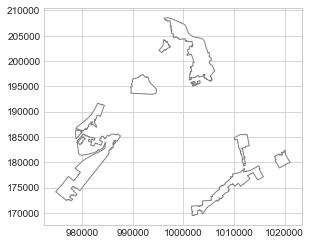

In [4]:
# plotting Brooklyn IBZ's
IBZ_NYC[IBZ_NYC.BORONAME == 'Brooklyn'].plot(color='white', edgecolor='grey')

### 1.2 IBZ NYC list of BBL by IBZ
downloaded pdf and copied data to a .csv file from https://www.nycedc.com/industry/industrial/nyc-industrial-business-zones

In [5]:
IBZ_bbl = pd.read_csv('data/IBZ_Brooklyn.csv')
IBZ_bbl = IBZ_bbl[['IBZ Area','Borough','BBL']]

print(IBZ_bbl.shape)
IBZ_bbl.head()

(4450, 3)


,IBZ Area,Borough,BBL
0,Southwest Brooklyn,Brooklyn,3002810001
1,Southwest Brooklyn,Brooklyn,3002810062
2,Southwest Brooklyn,Brooklyn,3003140001
3,Southwest Brooklyn,Brooklyn,3003140036
4,Southwest Brooklyn,Brooklyn,3003140027


In [6]:
IBZ_bbl.BBL.dtypes

dtype('int64')

In [ ]:
import csv

def reducer(accum, current):
    if current['Borough']=='BK':
        day = current['starttime'].split(' ')[0]
        if len(accum)==0 or accum[-1][0]!=day:
            return accum + [(day, int(current['birth_year']))]
    return accum     

with open('citibike.csv', 'r') as fi:
    reader = csv.DictReader(fi)
    print(reduce(reducer, reader, []))

## 1.3 MapPLUTO data
retrieved from https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page#mappluto

In [ ]:
# from https://gis.stackexchange.com/questions/220023/only-read-specific-rows-of-a-shapefile-with-geopandas-fiona
# unhash second part when running first time

# # Dana's attempts to change the function
# def records(filename, borough, list):
#     list = sorted(list) # if the elements of the list are not sorted
#     with fiona.open(filename) as source:
#         filter = (source['Borough'] == borough)
#         for i, feature in enumerate(source[:max(list)+1]):
#             if i in list:
#                 if feature in filter:
#                     yield feature  

# def records(filename, list):
#     list = sorted(list) # if the elements of the list are not sorted
#     with fiona.open(filename) as source:
#         for i, feature in enumerate(source[:max(list)+1]):
#             if i in list:
#                 yield feature

In [83]:
# MapPLUTO_1 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(200000,220000)))
# MapPLUTO_1 = MapPLUTO_1[MapPLUTO_1.Borough == 'BK'] # BK only
# MapPLUTO_2 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(220000,240000)))
# MapPLUTO_2 = MapPLUTO_2[MapPLUTO_2.Borough == 'BK'] # BK only
# MapPLUTO_3 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(240000,260000)))
# MapPLUTO_3 = MapPLUTO_3[MapPLUTO_3.Borough == 'BK'] # BK only
# MapPLUTO_4 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(260000,280000)))
# MapPLUTO_4 = MapPLUTO_4[MapPLUTO_4.Borough == 'BK'] # BK only
# MapPLUTO_5 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(280000,300000)))
# MapPLUTO_5 = MapPLUTO_5[MapPLUTO_5.Borough == 'BK'] # BK only
# MapPLUTO_6 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(300000,320000)))
# MapPLUTO_6 = MapPLUTO_6[MapPLUTO_6.Borough == 'BK'] # BK only
# MapPLUTO_7 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(320000,340000)))
# MapPLUTO_7 = MapPLUTO_7[MapPLUTO_7.Borough == 'BK'] # BK only
# MapPLUTO_8 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(340000,360000)))
# MapPLUTO_8 = MapPLUTO_8[MapPLUTO_8.Borough == 'BK'] # BK only
# MapPLUTO_9 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(180000,200000)))
# MapPLUTO_9 = MapPLUTO_9[MapPLUTO_9.Borough == 'BK'] # BK only
# MapPLUTO_10 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(160000,180000)))
# MapPLUTO_10 = MapPLUTO_10[MapPLUTO_10.Borough == 'BK'] # BK only
# MapPLUTO_11 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(140000,160000)))
# MapPLUTO_11 = MapPLUTO_11[MapPLUTO_11.Borough == 'BK'] # BK only
# MapPLUTO_12 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(400000,420000)))
# MapPLUTO_12 = MapPLUTO_12[MapPLUTO_12.Borough == 'BK'] # BK only
# MapPLUTO_13 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(120000,140000)))
# MapPLUTO_13 = MapPLUTO_13[MapPLUTO_13.Borough == 'BK'] # BK only
# MapPLUTO_14 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(360000,380000)))
# MapPLUTO_14 = MapPLUTO_14[MapPLUTO_14.Borough == 'BK'] # BK only
# MapPLUTO_15 = gpd.GeoDataFrame.from_features(records("data/shp_MapPLUTO/MapPLUTO.shp", range(380000,400000)))
# MapPLUTO_15 = MapPLUTO_15[MapPLUTO_15.Borough == 'BK'] # BK only


MapPLUTO_test = gpd.GeoDataFrame(pd.concat([MapPLUTO_1,MapPLUTO_2,MapPLUTO_3,
                                            MapPLUTO_4,MapPLUTO_5,MapPLUTO_6,
                                            MapPLUTO_7,MapPLUTO_8,MapPLUTO_9,
                                            MapPLUTO_10,MapPLUTO_11,MapPLUTO_12,
                                            MapPLUTO_13,MapPLUTO_14,MapPLUTO_15],
                                            ignore_index=True))

# converting BBL to int
MapPLUTO_test.BBL = (MapPLUTO_test.BBL).astype(int)

# dropping columns
MapPLUTO_test = MapPLUTO_test.drop(['APPBBL', 'APPDate','AreaSource','BldgDepth','BldgFront',
                                   'BsmtCode','CB2010','EDesigNum','Easements','ExemptLand',
                                   'ExemptTot','Ext','FIRM07_FLA','FireComp','GarageArea',
                                   'HealthArea','HealthCent','HistDist','IrrLotCode','Landmark',
                                   'BoroCode','LtdHeight','OwnerName','PFIRM15_FL','PolicePrct',
                                   'ProxCode','XCoord','YCoord','Sanborn','SanitDistr','SanitSub',
                                   'TaxMap','Sanitboro','SchoolDist','Tract2010','Version',
                                   'YearBuilt','YearAlter1','YearAlter2','ZMCode','ZipCode',
                                   'PLUTOMapID','SplitZone','Overlay2','ZoneDist3',
                                   'ZoneDist4'],axis=1)

print(MapPLUTO_test.shape)
print(MapPLUTO_test.BBL.dtypes)
MapPLUTO_test.head()

(276532, 44)
int64


,Address,AssessLand,AssessTot,BBL,BldgArea,BldgClass,Block,Borough,BuiltFAR,CD,...,SPDist3,Shape_Area,Shape_Leng,StrgeArea,UnitsRes,UnitsTotal,ZoneDist1,ZoneDist2,ZoneMap,geometry
0,75 LYNCH STREET,27336.0,75427.0,3022310045,7918,B1,2231,BK,2.20,301,...,,3909.927176,283.574417,0,2,2,R6,,13b,"POLYGON ((996553.1433607191 194809.100260973, ..."
1,71 LYNCH STREET,10089.0,69088.0,3022310049,7920,C0,2231,BK,1.80,301,...,,4509.209986,295.032845,0,3,3,R6,,13b,"POLYGON ((996566.2614447176 194736.2132676393,..."
2,67 LYNCH STREET,5632.0,54432.0,3022310051,8160,C0,2231,BK,4.08,301,...,,3788.086793,281.146852,0,3,3,R6,,13b,"POLYGON ((996518.3396245539 194695.5174828917,..."
3,61 LYNCH STREET,3242.0,7404.0,3022310055,1537,A9,2231,BK,1.18,301,...,,1233.785385,232.074564,0,1,1,R6,,13b,"POLYGON ((996472.99063389 194657.0070612282, 9..."
4,59 LYNCH STREET,1242.0,7404.0,3022310056,1537,A9,2231,BK,1.18,301,...,,1323.432542,233.780200,0,1,1,R6,,13b,"POLYGON ((996463.9647333026 194649.3423783928,..."


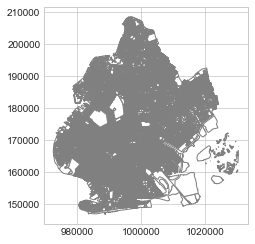

In [22]:
# plotting Brooklyn MapPLUTO
MapPLUTO_test.plot(color='white', edgecolor='grey')

In [18]:
MapPLUTO_test.to_file('MapPLUTO_test_BK.shp', driver='ESRI Shapefile')

## 1.4 PLUTO from http://chriswhong.github.io/plutoplus/#

In [165]:
PLUTO_BK = gpd.GeoDataFrame.from_file('data/pluto/pluto.shp')
PLUTO_BK = PLUTO_BK[PLUTO_BK.borough == 'BK']
PLUTO_BK.bbl = (PLUTO_BK.bbl).astype(int)

print(PLUTO_BK.shape)
PLUTO_BK.head()

(272790, 21)


,zonedist1,bbl,block,borough,builtfar,facilfar,factryarea,landuse,lot,address,...,numbldgs,numfloors,overlay1,resarea,residfar,spdist1,unitsres,unitstotal,lotarea,geometry
0,R6B,3003600055,360,BK,2.25,2.0,0,02,55,3 2 PLACE,...,1,3.0,,2160,2.0,,3,3,1279,POLYGON ((-74.00070968489754 40.68085391486006...
1,R6B,3003550049,355,BK,2.19,2.0,0,01,49,3 1 PLACE,...,1,3.0,,3525,2.0,,2,2,2150,POLYGON ((-74.00027976125477 40.68173164159477...
2,M1-4/R8A,3000400001,40,BK,7.77,6.5,128000,05,1,68 JAY STREET,...,1,10.0,,0,5.4,MX-2,0,155,41200,POLYGON ((-73.98673430163642 40.70305305205899...
3,R6B,3001210023,121,BK,1.60,2.0,0,02,23,184 CONCORD STREET,...,2,3.0,,4000,2.0,,3,3,2504,"POLYGON ((-73.9836716292812 40.69749815851373,..."
4,R6B,3001730047,173,BK,2.25,2.0,0,02,47,447 STATE STREET,...,1,4.0,,4980,2.0,DB,4,4,2212,POLYGON ((-73.98106254605777 40.68670524004344...


In [169]:
# merging BK with IBZ
IBZ_joint_2 = PLUTO_BK.merge(IBZ_bbl, left_on='bbl', right_on='BBL')
                                
print(IBZ_joint_2.shape)
IBZ_joint_2.head()

(4399, 24)


,zonedist1,bbl,block,borough,builtfar,facilfar,factryarea,landuse,lot,address,...,resarea,residfar,spdist1,unitsres,unitstotal,lotarea,geometry,IBZ Area,Borough,BBL
0,M1-1,3005080038,508,BK,2.02,2.4,7800,06,38,62 SEABRING STREET,...,0,0.0,,0,1,3856,POLYGON ((-74.00701552412471 40.68144521404673...,Southwest Brooklyn,Brooklyn,3005080038
1,M2-1,3005640014,564,BK,1.14,0.0,0,01,14,155 SULLIVAN STREET,...,2260,0.0,,2,2,1983,POLYGON ((-74.01449387920651 40.67925263171069...,Southwest Brooklyn,Brooklyn,3005640014
2,M3-1,3006440080,644,BK,0.99,0.0,0,10,80,704 3 AVENUE,...,0,0.0,,0,1,5033,POLYGON ((-73.99869664277087 40.66333303388076...,Southwest Brooklyn,Brooklyn,3006440080
3,M1-2,3007070009,707,BK,1.99,4.8,0,05,9,3901 2 AVENUE,...,0,0.0,,0,2,2517,POLYGON ((-74.01018590071838 40.65495263422093...,Southwest Brooklyn,Brooklyn,3007070009
4,M1-2,3007220028,722,BK,0.90,4.8,0,06,28,256 42 STREET,...,0,0.0,,0,1,2504,POLYGON ((-74.01086905395167 40.65263438302985...,Southwest Brooklyn,Brooklyn,3007220028


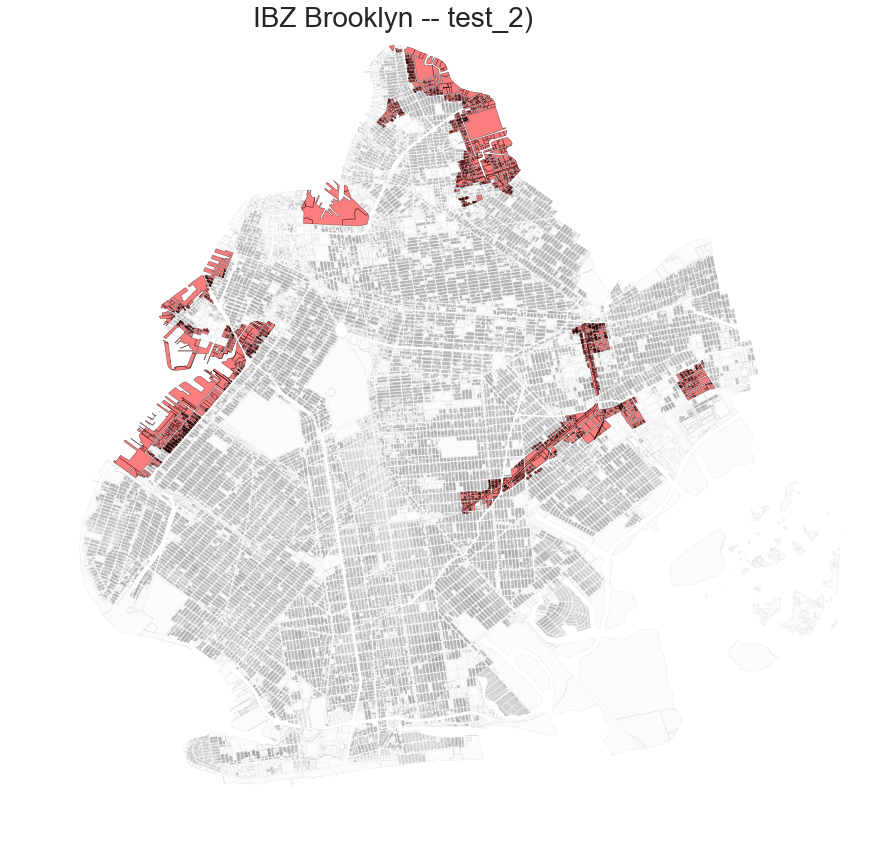

In [170]:
# plotting IBZ lots over all lots

fig = pl.figure(figsize=(15,15))
ax = fig.add_subplot(111)
BK.plot(ax=ax, color='lightgrey', edgecolor='k',linewidth=.5, alpha=0.08)
IBZ_joint_2.plot(ax=ax, color='red', edgecolor='k',linewidth=.5, alpha=0.5);
# IBZ_NYC[IBZ_NYC.BORONAME == 'Brooklyn'].plot(ax=ax, color='None', edgecolor='r', linestyle='dashed',linewidth=1);

plt.title('IBZ Brooklyn -- test_2)', size=28, y=.97, x=0.42)
tmp = ax.axis('off')

----
## 1.4 Merging MapPLUTO with IBZ csv

In [191]:
IBZ_joint = MapPLUTO_test.merge(IBZ_bbl, on='BBL')
                                
print(IBZ_joint.shape)
IBZ_joint.head()

(4406, 46)


,Address,AssessLand,AssessTot,BBL,BldgArea,BldgClass,Block,Borough_x,BuiltFAR,CD,...,Shape_Leng,StrgeArea,UnitsRes,UnitsTotal,ZoneDist1,ZoneDist2,ZoneMap,geometry,IBZ Area,Borough_y
0,17 KENT AVENUE,11178.0,66380.0,3022780001,5000,S3,2278,BK,2.00,301,...,261.028240,0,3,4,M1-2,,12c,"POLYGON ((995967.7757650614 202858.7442666441,...",Greenpoint/Williamsburg,Brooklyn
1,9 KENT AVENUE,1202850.0,3015000.0,3022780002,111300,F1,2278,BK,1.42,301,...,1275.752403,0,0,1,M1-2,,12c,"POLYGON ((995967.7757650614 202858.7442666441,...",Greenpoint/Williamsburg,Brooklyn
2,29 WYTHE AVENUE,324000.0,1141200.0,3022790001,21000,E1,2279,BK,1.05,301,...,624.194145,0,0,3,M1-2,,13a,"POLYGON ((996454.5257758051 202728.6992511451,...",Greenpoint/Williamsburg,Brooklyn
3,180 NORTH 14 STREET,86400.0,349650.0,3022790009,8528,J6,2279,BK,1.00,301,...,382.092555,0,0,1,M1-2,,13a,"POLYGON ((996521.122427389 202674.4355801493, ...",Greenpoint/Williamsburg,Brooklyn
4,190 NORTH 14 STREET,64800.0,359550.0,3022790013,8765,J6,2279,BK,2.19,301,...,292.023862,0,1,2,M1-2,,13a,"POLYGON ((996552.8461172283 202648.586878553, ...",Greenpoint/Williamsburg,Brooklyn


In [176]:
IBZ_joint.to_file('PLUTO_BK_IBZ.shp')

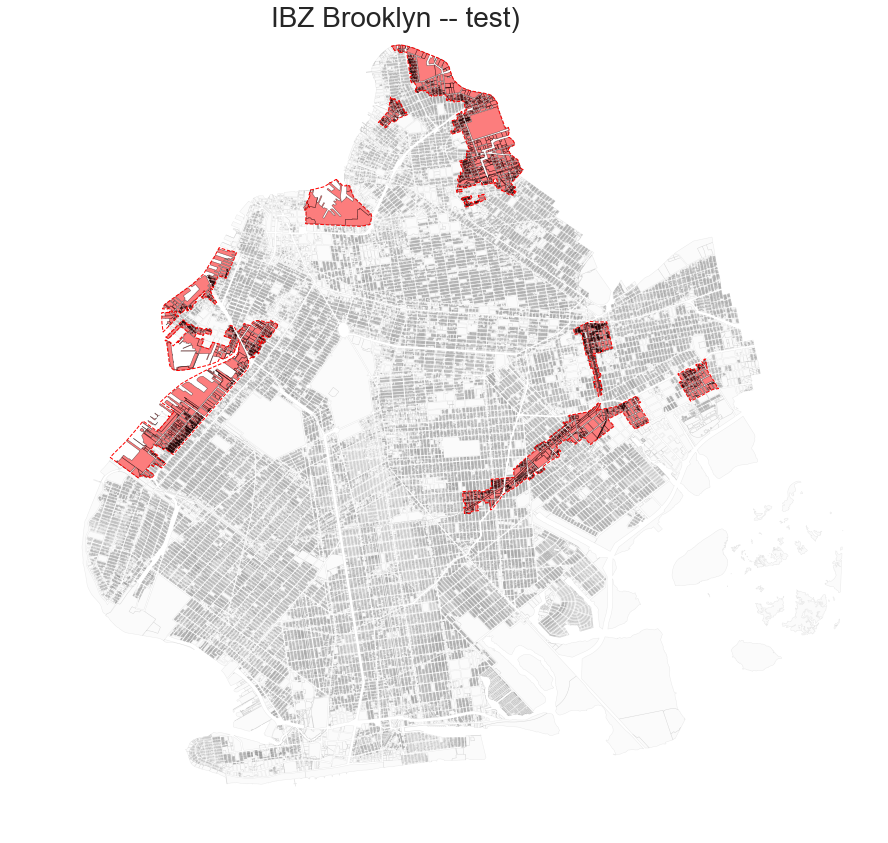

In [64]:
# plotting IBZ lots over all lots

fig = pl.figure(figsize=(15,15))
ax = fig.add_subplot(111)
MapPLUTO_test.plot(ax=ax, color='lightgrey', edgecolor='k',linewidth=.5, alpha=0.08)
IBZ_joint.plot(ax=ax, color='red', edgecolor='k',linewidth=.5, alpha=0.5);
IBZ_NYC[IBZ_NYC.BORONAME == 'Brooklyn'].plot(ax=ax, color='None', edgecolor='r', linestyle='dashed',linewidth=1);

plt.title("IBZ's Brooklyn", size=28, y=.97, x=0.42)
tmp = ax.axis('off')

----
## ** [PLUTO data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?r=18v2beta)
Detailing different categories from the data
1. **BUILDING CLASS (BldgClass)**: A code describing the major use of structures on the tax lot
2. **LAND USE CATEGORY (LandUse)**:<br>
    | VALUE   | DESCRIPTION                              |        
    | ------- |:----------------------------------------:| 
    | 01      | One & Two Family Buildings               | 
    | 02      | Multi-Family Walk-Up Buildings           |   
    | 03      | Multi-Family Elevator Buildings          |
    | 04      | Mixed Residential & Commercial Buildings | 
    | 05      | Commercial & Office Buildings            |   
    | 06      | Industrial & Manufacturing               |
    | 07      | Transportation & Utility                 | 
    | 08      | Public Facilities & Institutions         |   
    | 09      | Open Space & Outdoor Recreation          |
    | 10      | Parking Facilities                       |   
    | 11      | Vacant Land                              |  

----
# 2. Exploratory analysis of IBZ lots (_BK only_)
## 2.1 Lot types, Land uses and Zoning distributions

In [192]:
IBZ_joint.LotType.value_counts()

5    3162
3    1002
4     167
1      23
0      21
8      12
2       9
6       7
        3
Name: LotType, dtype: int64

In [193]:
print(list(IBZ_joint.LandUse.unique()))

# renaming LandUse according to the PLUTO dictionary 
IBZ_joint.LandUse = IBZ_joint.LandUse.replace(to_replace=
                    {'01': 'One & Two Family Buildings',
                     '02': 'Multi-Family Walk-Up Buildings',
                     '03': 'Multi-Family Elevator Buildings',
                     '04': 'Mixed Residential & Commercial Buildings',
                     '05': 'Commercial & Office Buildings',
                     '06': 'Industrial & Manufacturing',
                     '07': 'Transportation & Utility',
                     '08': 'Public Facilities & Institutions',
                     '09': 'Open Space & Outdoor Recreation',
                     '10': 'Parking Facilities',
                     '11': 'Vacant Land',
                     '': 'Unknown'})

IBZ_joint.LandUse.unique()

['04', '06', '05', '02', '', '10', '07', '08', '01', '11', '03', '09']


array(['Mixed Residential & Commercial Buildings',
       'Industrial & Manufacturing', 'Commercial & Office Buildings',
       'Multi-Family Walk-Up Buildings', 'Unknown', 'Parking Facilities',
       'Transportation & Utility', 'Public Facilities & Institutions',
       'One & Two Family Buildings', 'Vacant Land',
       'Multi-Family Elevator Buildings',
       'Open Space & Outdoor Recreation'], dtype=object)

In [195]:
IBZ_joint.LandUse.value_counts()

Industrial & Manufacturing                  1891
Parking Facilities                           519
Transportation & Utility                     385
Unknown                                      361
One & Two Family Buildings                   307
Vacant Land                                  297
Commercial & Office Buildings                261
Multi-Family Walk-Up Buildings               158
Mixed Residential & Commercial Buildings     149
Public Facilities & Institutions              67
Open Space & Outdoor Recreation                9
Multi-Family Elevator Buildings                2
Name: LandUse, dtype: int64

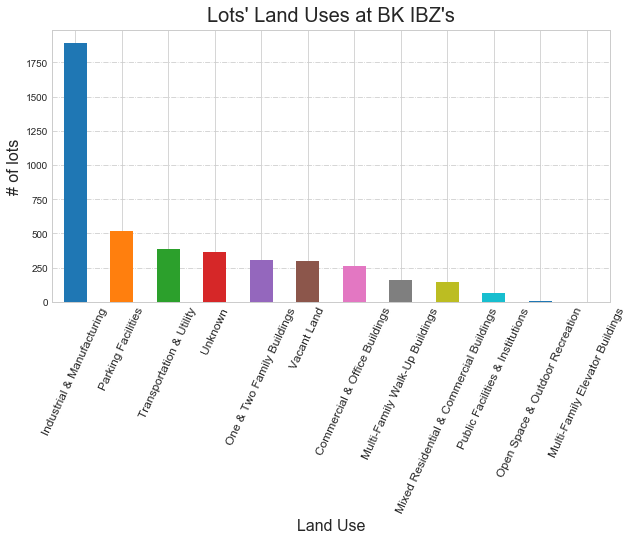

In [229]:
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(111)
IBZ_joint.LandUse.value_counts().plot(ax=ax, kind='bar')

plt.title("Lots' Land Uses at BK IBZ's", size=20, y=1.01)
plt.xlabel("Land Use", size=16)
plt.ylabel("# of lots", size=16)
plt.xticks(rotation=65, size=12)
ax.grid(axis='y', linestyle='-.');

_Fig.2_: Lots by Land Use; **307 lots** are for _'One & Two Family Buildings'_ use, **167 lots** are for _'Multi-Family'_ use, and **149 lots** are for _'Mixed Residential & Commercial Buildings'_ use. Overall, these are **14% of all IBZ BK lots**. It is important to understand their **% in their own block**, therefore we will create a new table of land use per block per lot.

R6B    5
R4     4
       4
R6     3
R5     3
Name: ZoneDist1, dtype: int64


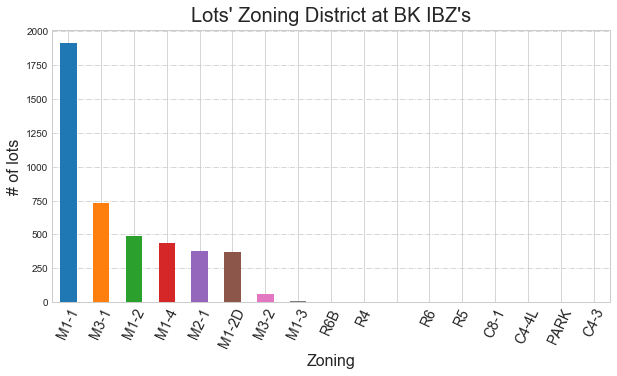

In [231]:
print(IBZ_joint.ZoneDist1.value_counts()[8:13])

fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(111)
IBZ_joint.ZoneDist1.value_counts().plot(ax=ax, kind='bar')

plt.title("Lots' Zoning District at BK IBZ's", size=20, y=1.01)
plt.xlabel("Zoning", size=16)
plt.ylabel("# of lots", size=16)
plt.xticks(rotation=65, size=14)
ax.grid(axis='y', linestyle='-.');

_Fig.3_: Lots by Zoning Districts; Only **15 lots from all 4406 lots (0.3%)** in IBZ BK are Residential zoned.

## 2.2 What % of lots per block are residential designated? 
### 2.2.1 Land Use
- Pivot table to include *Block* as index, Land Use / Resi

In [309]:
blocks = pd.pivot_table(IBZ_joint, values='Lot', index=['Block'], columns='LandUse')


# counting lots per block per land use
blocks['Commercial & Office Buildings'] = IBZ_joint['Block'][IBZ_joint['LandUse'] == 'Commercial & Office Buildings']\
                                                                                .groupby([IBZ_joint['Block']]).count()
blocks['Industrial & Manufacturing'] = IBZ_joint['Block'][IBZ_joint['LandUse'] == 'Industrial & Manufacturing']\
                                                                         .groupby([IBZ_joint['Block']]).count()
blocks['Mixed Residential & Commercial Buildings'] = IBZ_joint['Block'][IBZ_joint['LandUse'] == 'Mixed Residential & Commercial Buildings']\
                                                                                                     .groupby([IBZ_joint['Block']]).count()
blocks['Multi-Family Elevator Buildings'] = IBZ_joint['Block'][IBZ_joint['LandUse'] == 'Multi-Family Elevator Buildings']\
                                                                                    .groupby([IBZ_joint['Block']]).count()
blocks['Multi-Family Walk-Up Buildings'] = IBZ_joint['Block'][IBZ_joint['LandUse'] == 'Multi-Family Walk-Up Buildings']\
                                                                                  .groupby([IBZ_joint['Block']]).count()
blocks['One & Two Family Buildings'] = IBZ_joint['Block'][IBZ_joint['LandUse'] == 'One & Two Family Buildings']\
                                                                          .groupby([IBZ_joint['Block']]).count()
blocks['Open Space & Outdoor Recreation'] = IBZ_joint['Block'][IBZ_joint['LandUse'] == 'Open Space & Outdoor Recreation']\
                                                                                    .groupby([IBZ_joint['Block']]).count()
blocks['Parking Facilities'] = IBZ_joint['Block'][IBZ_joint['LandUse'] == 'Parking Facilities']\
                                                          .groupby([IBZ_joint['Block']]).count()
blocks['Public Facilities & Institutions'] = IBZ_joint['Block'][IBZ_joint['LandUse'] == 'Public Facilities & Institutions']\
                                                                                      .groupby([IBZ_joint['Block']]).count()
blocks['Transportation & Utility'] = IBZ_joint['Block'][IBZ_joint['LandUse'] == 'Transportation & Utility']\
                                                                      .groupby([IBZ_joint['Block']]).count()
blocks['Unknown'] = IBZ_joint['Block'][IBZ_joint['LandUse'] == 'Unknown']\
                                    .groupby([IBZ_joint['Block']]).count()
blocks['Vacant Land'] = IBZ_joint['Block'][IBZ_joint['LandUse'] == 'Vacant Land']\
                                            .groupby([IBZ_joint['Block']]).count()

# fillna > filling Nan's to 0
blocks = blocks.fillna(0).astype(int)

# total # of lots per block
blocks['TotalLots'] = blocks.sum(axis=1)
# total # of lots that are designated to resi
blocks['resiLots'] = blocks['Mixed Residential & Commercial Buildings'] + \
                     blocks['Multi-Family Elevator Buildings'] + \
                     blocks['Multi-Family Walk-Up Buildings'] + \
                     blocks['One & Two Family Buildings']
# % of resi lots from all lots in block
blocks['resi_%'] = ((blocks['resiLots'] / blocks['TotalLots']).round(2)*100).astype(int)

blocks.head(10)

LandUse,Commercial & Office Buildings,Industrial & Manufacturing,Mixed Residential & Commercial Buildings,Multi-Family Elevator Buildings,Multi-Family Walk-Up Buildings,One & Two Family Buildings,Open Space & Outdoor Recreation,Parking Facilities,Public Facilities & Institutions,Transportation & Utility,Unknown,Vacant Land,TotalLots,resiLots,resi_%
Block,,,,,,,,,,,,,,,
281,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0
314,0,0,0,0,0,0,0,2,0,0,1,5,8,0,0
316,0,0,0,0,0,0,0,0,0,0,1,6,7,0,0
318,0,0,0,0,0,0,0,0,0,0,11,0,11,0,0
334,1,1,0,0,0,0,0,0,0,0,0,25,27,0,0
340,0,0,0,0,0,0,0,0,0,0,0,40,40,0,0
346,0,0,0,0,0,0,0,0,0,0,3,12,15,0,0
477,1,1,0,0,0,0,0,0,0,1,0,1,4,0,0
479,0,2,1,0,1,0,0,0,0,0,0,0,4,2,50


In [390]:
print('# of blocks that more than 30% of their lots are designated to residential uses: ',
      blocks[blocks['resi_%'] >= 30].shape[0], ' blocks (out of 516 blocks at BK IBZ)')

print('\nThe list of these blocks is:\n',list((blocks[blocks['resi_%'] >= 30]).index))

# of blocks that more than 30% of their lots are designated to residential uses:  44  blocks (out of 516 blocks at BK IBZ)

The list of these blocks is:
 [479, 555, 574, 599, 695, 722, 727, 736, 745, 781, 789, 797, 805, 813, 845, 1008, 2278, 2295, 2506, 2593, 2600, 2643, 2835, 2836, 2842, 2843, 3682, 3685, 3750, 3833, 3850, 3881, 4342, 4343, 4383, 4482, 4501, 4503, 7745, 7746, 7949, 8114, 8124, 8128]


In [402]:
resi_LandUse = blocks[blocks['resi_%'] >= 30][['TotalLots','resi_%']]
resi_LandUse.head(3)

LandUse,TotalLots,resi_%
Block,,
479,4,50
555,5,40
574,10,30


### 2.2.2 Zoning District
- Pivot table to include *Block* as index, ZoneDist1 / Resi

In [321]:
print(list(IBZ_joint['ZoneDist1'].unique()))

['M1-2', 'M1-1', 'M3-1', 'R6B', 'R6', 'M1-4', 'M3-2', 'C4-3', 'C4-4L', '', 'M1-3', 'M2-1', 'C8-1', 'R5', 'M1-2D', 'PARK', 'R4']


In [326]:
blocks_zone = pd.pivot_table(IBZ_joint, values='Lot', index=['Block'], columns='ZoneDist1')

# counting lots per block per land use
blocks_zone['M1-2'] = IBZ_joint['Block'][IBZ_joint['ZoneDist1'] == 'M1-2']\
                                     .groupby([IBZ_joint['Block']]).count()
blocks_zone['M1-1'] = IBZ_joint['Block'][IBZ_joint['ZoneDist1'] == 'M1-1']\
                                     .groupby([IBZ_joint['Block']]).count()
blocks_zone['M3-1'] = IBZ_joint['Block'][IBZ_joint['ZoneDist1'] == 'M3-1']\
                                     .groupby([IBZ_joint['Block']]).count()
blocks_zone['R6B'] = IBZ_joint['Block'][IBZ_joint['ZoneDist1'] == 'R6B']\
                                   .groupby([IBZ_joint['Block']]).count()
blocks_zone['R6'] = IBZ_joint['Block'][IBZ_joint['ZoneDist1'] == 'R6']\
                                 .groupby([IBZ_joint['Block']]).count()
blocks_zone['M1-4'] = IBZ_joint['Block'][IBZ_joint['ZoneDist1'] == 'M1-4']\
                                     .groupby([IBZ_joint['Block']]).count()
blocks_zone['M3-2'] = IBZ_joint['Block'][IBZ_joint['ZoneDist1'] == 'M3-2']\
                                     .groupby([IBZ_joint['Block']]).count()
blocks_zone['C4-3'] = IBZ_joint['Block'][IBZ_joint['ZoneDist1'] == 'C4-3']\
                                     .groupby([IBZ_joint['Block']]).count()
blocks_zone['C4-4L'] = IBZ_joint['Block'][IBZ_joint['ZoneDist1'] == 'C4-4L']\
                                       .groupby([IBZ_joint['Block']]).count()
blocks_zone[''] = IBZ_joint['Block'][IBZ_joint['ZoneDist1'] == '']\
                             .groupby([IBZ_joint['Block']]).count()
blocks_zone['M1-3'] = IBZ_joint['Block'][IBZ_joint['ZoneDist1'] == 'M1-3']\
                                     .groupby([IBZ_joint['Block']]).count()
blocks_zone['M2-1'] = IBZ_joint['Block'][IBZ_joint['ZoneDist1'] == 'M2-1']\
                                     .groupby([IBZ_joint['Block']]).count()
blocks_zone['C8-1'] = IBZ_joint['Block'][IBZ_joint['ZoneDist1'] == 'C8-1']\
                                     .groupby([IBZ_joint['Block']]).count()
blocks_zone['R5'] = IBZ_joint['Block'][IBZ_joint['ZoneDist1'] == 'R5']\
                                 .groupby([IBZ_joint['Block']]).count()
blocks_zone['M1-2D'] = IBZ_joint['Block'][IBZ_joint['ZoneDist1'] == 'M1-2D']\
                                       .groupby([IBZ_joint['Block']]).count()
blocks_zone['PARK'] = IBZ_joint['Block'][IBZ_joint['ZoneDist1'] == 'PARK']\
                                     .groupby([IBZ_joint['Block']]).count()
blocks_zone['R4'] = IBZ_joint['Block'][IBZ_joint['ZoneDist1'] == 'R4']\
                                 .groupby([IBZ_joint['Block']]).count()


# fillna > filling Nan's to 0
blocks_zone = blocks_zone.fillna(0).astype(int)

# total # of lots per block
blocks_zone['TotalLots'] = blocks_zone.sum(axis=1)
# total # of lots that are designated to resi
blocks_zone['resiLots'] = blocks_zone['R4'] + \
                          blocks_zone['R5'] + \
                          blocks_zone['R6'] + \
                          blocks_zone['R6B']
# % of resi lots from all lots in block
blocks_zone['resi_%'] = ((blocks_zone['resiLots'] / blocks_zone['TotalLots']).round(2)*100).astype(int)

blocks_zone.head(3)

ZoneDist1,,C4-3,C4-4L,C8-1,M1-1,M1-2,M1-2D,M1-3,M1-4,M2-1,M3-1,M3-2,PARK,R4,R5,R6,R6B,TotalLots,resiLots,resi_%
Block,,,,,,,,,,,,,,,,,,,,
281,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0
314,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0
316,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0


In [330]:
# how many blocks contain more than 0% of residential zones?
print('# of blocks that more than 0% of their lots are zoned to residential uses: ',
      blocks_zone[blocks_zone['resi_%'] != 0].shape[0], ' blocks (out of 516 blocks at BK IBZ)\n\n')

blocks_zone[blocks_zone['resi_%'] != 0]

# of blocks that more than 0% of their lots are zoned to residential uses:  9  blocks (out of 516 blocks at BK IBZ)




ZoneDist1,,C4-3,C4-4L,C8-1,M1-1,M1-2,M1-2D,M1-3,M1-4,M2-1,M3-1,M3-2,PARK,R4,R5,R6,R6B,TotalLots,resiLots,resi_%
Block,,,,,,,,,,,,,,,,,,,,
552,0,0,0,0,13,0,0,0,0,0,0,0,0,0,1,0,0,14,1,7
562,0,0,0,0,15,0,0,0,0,0,0,0,0,0,1,0,0,16,1,6
580,0,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,0,5,1,20
2023,0,0,0,0,0,0,0,0,1,0,5,0,0,0,0,0,1,7,1,14
2600,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,4,8,4,50
3109,0,0,0,0,15,14,0,0,0,0,0,0,0,0,0,2,0,31,2,6
3799,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,1,0,4,1,25
7746,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,3,2,67
8128,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,2,100


In [392]:
# how many blocks contain more than 25% of residential zones?
print('# of blocks that more than 30% of their lots are zoned to residential uses: ',
      blocks_zone[blocks_zone['resi_%'] >= 30].shape[0], ' blocks (out of 516 blocks at BK IBZ)\n\n')

blocks_zone[blocks_zone['resi_%'] >= 30]

# of blocks that more than 30% of their lots are zoned to residential uses:  3  blocks (out of 516 blocks at BK IBZ)




ZoneDist1,,C4-3,C4-4L,C8-1,M1-1,M1-2,M1-2D,M1-3,M1-4,M2-1,M3-1,M3-2,PARK,R4,R5,R6,R6B,TotalLots,resiLots,resi_%
Block,,,,,,,,,,,,,,,,,,,,
2600,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,4,8,4,50
7746,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,3,2,67
8128,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,2,100


## _The above results do not apply to our block at Wolcott st. as it is all zoned to M2-1_

----
## 2.3 What % of built FAR is built to residential uses

### From PLUTO data dictionary, _ResidFAR_ is the _MAXIMUM ALLOWABLE RESIDENTIAL FAR_ in a lot. This DOESN'T mean the actual BUILT resi FAR, and thus it is hard to compare it to / calculate it with the _BuiltFAR_ variable which is an assessment of the already built area divided by the lot's area. Detailed description of _ResidFAR_ variable:

The maximum allowable residential floor area ratio.
The maximum allowable residential floor area ratios are exclusive of bonuses for
plazas, plaza-connected open areas, arcades, or other amenities.
For properties zoned R6, R7, R7-1, R8 or R9 the maximum allowable floor area
reflects the maximum achievable floor area under ideal conditions.
The maximum allowable floor area does not reflect Voluntary Inclusionary Housing
or Mandatory Inclusionary Housing Program floor area. See Appendix F and Section
23-154, paragraphs (b) and (d) of the Zoning Resolution.
For properties in special mixed use districts, PLUTO uses the wide street maximum
allowable floor area ratio. Since the maximum allowable floor area ratio in mixed use
special districts is actually determined by whether the property is located on a wide 

In [310]:
IBZ_joint.columns

Index(['Address', 'AssessLand', 'AssessTot', 'BBL', 'BldgArea', 'BldgClass',
       'Block', 'Borough_x', 'BuiltFAR', 'CD', 'CT2010', 'ComArea', 'CommFAR',
       'CondoNo', 'Council', 'FacilFAR', 'FactryArea', 'LandUse', 'Lot',
       'LotArea', 'LotDepth', 'LotFront', 'LotType', 'NumBldgs', 'NumFloors',
       'OfficeArea', 'OtherArea', 'Overlay1', 'OwnerType', 'ResArea',
       'ResidFAR', 'RetailArea', 'SPDist1', 'SPDist2', 'SPDist3', 'Shape_Area',
       'Shape_Leng', 'StrgeArea', 'UnitsRes', 'UnitsTotal', 'ZoneDist1',
       'ZoneDist2', 'ZoneMap', 'geometry', 'IBZ Area', 'Borough_y'],
      dtype='object')

In [350]:
IBZ_blocks = IBZ_joint.set_index('Block')
IBZ_blocks = IBZ_blocks[['Address','LotArea','BldgArea','ResArea','BuiltFAR','ResidFAR','UnitsRes','UnitsTotal']]

# resi BUILT FAR
IBZ_blocks['resBuiltFAR'] = (IBZ_blocks['ResArea'] / IBZ_blocks['LotArea']).round(2)

# resi %
IBZ_blocks['resArea_%'] = (IBZ_blocks['ResArea'] / IBZ_blocks['BldgArea']).round(2)*100
IBZ_blocks['resUnits_%'] = IBZ_blocks['UnitsRes'] / IBZ_blocks['UnitsTotal']*100

print(IBZ_blocks.shape)
IBZ_blocks.head()

(4406, 11)


,Address,LotArea,BldgArea,ResArea,BuiltFAR,ResidFAR,UnitsRes,UnitsTotal,resBuiltFAR,resArea_%,resUnits_%
Block,,,,,,,,,,,
2278,17 KENT AVENUE,2500,5000,3010,2.00,0.0,3,4,1.20,60.0,75.0
2278,9 KENT AVENUE,78287,111300,0,1.42,0.0,0,1,0.00,0.0,0.0
2279,29 WYTHE AVENUE,20000,21000,0,1.05,0.0,0,3,0.00,0.0,0.0
2279,180 NORTH 14 STREET,8528,8528,0,1.00,0.0,0,1,0.00,0.0,0.0
2279,190 NORTH 14 STREET,4000,8765,1415,2.19,0.0,1,2,0.35,16.0,50.0


In [408]:
IBZ_blocks_grouped = IBZ_blocks.groupby('Block').sum()[['LotArea','BldgArea', 'ResArea', 'UnitsRes', 'UnitsTotal']]

# lotArea > BlockArea
IBZ_blocks_grouped = IBZ_blocks_grouped.rename(index=str, columns={"LotArea": "BlockArea"})

# Total BUILT FAR
IBZ_blocks_grouped['BuiltFAR'] = (IBZ_blocks_grouped['BldgArea'] / IBZ_blocks_grouped['BlockArea']).round(2)

# resi BUILT FAR
IBZ_blocks_grouped['resBuiltFAR'] = (IBZ_blocks_grouped['ResArea'] / IBZ_blocks_grouped['BlockArea']).round(2)

# resi %
IBZ_blocks_grouped['resArea_%'] = (IBZ_blocks_grouped['ResArea'] / IBZ_blocks_grouped['BldgArea']).round(2)*100
IBZ_blocks_grouped['resUnits_%'] = IBZ_blocks_grouped['UnitsRes'] / IBZ_blocks_grouped['UnitsTotal'].round(2)*100
IBZ_blocks_grouped['resFAR_%'] = (IBZ_blocks_grouped['resBuiltFAR'] / IBZ_blocks_grouped['BuiltFAR']).round(2)*100

# fillna > filling Nan's to 0
IBZ_blocks_grouped = IBZ_blocks_grouped.fillna(0)

print(IBZ_blocks_grouped.shape)
IBZ_blocks_grouped.iloc[:,-3:].head(10)

(516, 10)


,resArea_%,resUnits_%,resFAR_%
Block,,,
281,0.0,0.0,0.0
314,0.0,0.0,0.0
316,0.0,0.0,0.0
318,0.0,0.0,0.0
334,0.0,0.0,0.0
340,0.0,0.0,0.0
346,0.0,0.0,0.0
477,0.0,0.0,0.0
479,22.0,60.0,23.0


In [409]:
resi = IBZ_blocks_grouped[IBZ_blocks_grouped.resBuiltFAR != 0.0]
print(resi.shape)

resi_FAR = resi[resi['resFAR_%'] >= 30][['BuiltFAR','resBuiltFAR','resFAR_%']]

print('\nNumber of blocks that have more than 30% of built Residential FAR are:',
     resi_FAR.shape[0],'\n')

print('The blocks in BK IBZ that contain more than 30% of built Residential FAR are:\n',
      list(resi_FAR.index),'\n')

resi_FAR

(121, 10)

Number of blocks that have more than 30% of built Residential FAR are: 18 

The blocks in BK IBZ that contain more than 30% of built Residential FAR are:
 ['555', '606', '745', '781', '789', '813', '1008', '2593', '2600', '2835', '2836', '2843', '3124', '3799', '3850', '4342', '7745', '7962'] 



,BuiltFAR,resBuiltFAR,resFAR_%
Block,,,
555,1.00,0.62,62.0
606,0.10,0.07,70.0
745,1.47,0.64,44.0
781,1.08,0.35,32.0
789,1.24,0.51,41.0
813,1.33,0.72,54.0
1008,0.82,0.34,41.0
2593,3.05,2.37,78.0
2600,0.95,0.30,32.0


In [431]:
# looking for our block

resi.loc['574']

BlockArea      100001.00
BldgArea        43900.00
ResArea          8810.00
UnitsRes           13.00
UnitsTotal         16.00
BuiltFAR            0.44
resBuiltFAR         0.09
resArea_%          20.00
resUnits_%         81.25
resFAR_%           20.00
Name: 574, dtype: float64

In [441]:
resi_FAR_20 = resi[resi['resFAR_%'] >= 20][['BuiltFAR','resBuiltFAR','resFAR_%']]

print('\nNumber of blocks that have more than 20% of built Residential FAR are:',
     resi_FAR_20.shape[0],'\n')

print('The blocks in BK IBZ that contain more than 20% of built Residential FAR are:\n',
      list(resi_FAR_20.index),'\n')

resi_FAR_20


Number of blocks that have more than 20% of built Residential FAR are: 35 

The blocks in BK IBZ that contain more than 20% of built Residential FAR are:
 ['479', '555', '574', '598', '606', '736', '745', '781', '789', '797', '813', '845', '1008', '2279', '2534', '2593', '2600', '2835', '2836', '2842', '2843', '3124', '3677', '3681', '3682', '3712', '3716', '3799', '3850', '3871', '3881', '4342', '7745', '7746', '7962'] 



,BuiltFAR,resBuiltFAR,resFAR_%
Block,,,
479,1.14,0.26,23.0
555,1.00,0.62,62.0
574,0.44,0.09,20.0
598,0.78,0.19,24.0
606,0.10,0.07,70.0
736,1.70,0.42,25.0
745,1.47,0.64,44.0
781,1.08,0.35,32.0
789,1.24,0.51,41.0


In [438]:
# removing from the above all blocks that contain any residential zoning district
blocks_zone.index = blocks_zone.index.astype(str)

In [450]:
resi_zone = blocks_zone[blocks_zone['resi_%'] > 0]
print(resi_zone.shape)

for i in resi_FAR_20.index:
    if i in resi_zone.index:
        resi_FAR_20 = resi_FAR_20.drop(i)
        
resi_FAR_20.shape

(9, 20)


(32, 3)

----
## 2.4 Commercial overlay1

In [86]:
# lots that has an Overlay of C1-3
# There are 5 lots with C1-3 Overlay in BK IBZ's 
# There are no lots in BK IBZ's with Overlay2, thus this column was dropped from the dataset

IBZ_BK_reduced[IBZ_BK_reduced['Overlay1'] != ''].Overlay1

2544    C1-3
2545    C1-3
2558    C1-3
2576    C1-3
2619    C1-3
Name: Overlay1, dtype: object

----
# 3. Lookup of the blocks in BK IBZ that contain more than 30% of built Residential FAR
The blocks' numbers as identified above in **section 2.3** are:
['555', '606', '745', '781', '789', '813', '1008', '2593', '2600', '2835', '2836', '2843', '3124', '3799', '3850', '4342', '7745', '7962'] 

The goal of this phase is to identify the special characters of these 18 blocks; *are they adjacent to the IBZ boundary or to residential zone?*

In order to do so, we will use **ZoLa** at https://zola.planning.nyc.gov

For Brooklyn Historical Zoning/sketch maps, please click [here](https://www1.nyc.gov/assets/planning/download/pdf/zoning/zoning-maps/historical-sketch-maps/his_sketch_bk.pdf?r=0516)

In [419]:
resi_LandUse.index = resi_LandUse.index.astype(str)
resi_LandUse.index.dtype

dtype('O')

In [424]:
IBZ_joint.Block = IBZ_joint.Block.astype(str)
IBZ_joint.Block.dtype

dtype('O')

### resi_FAR >= 30%

In [426]:
# merging resi_FAR > 30% df with resi_LandUse
resi_FAR_LandUse = resi_FAR.merge(resi_LandUse, left_index=True, right_index=True)
resi_FAR_LandUse = resi_FAR_LandUse.rename(index=str, columns={"resFAR_%":"res_FAR%",
                                                          "resi_%": "resi_LandUse%"})

print(resi_FAR_LandUse.shape, type(resi_FAR_LandUse))
resi_FAR_LandUse

(14, 5) <class 'pandas.core.frame.DataFrame'>


,BuiltFAR,resBuiltFAR,res_FAR%,TotalLots,resi_LandUse%
Block,,,,,
555,1.00,0.62,62.0,5,40
745,1.47,0.64,44.0,41,66
781,1.08,0.35,32.0,42,60
789,1.24,0.51,41.0,42,69
813,1.33,0.72,54.0,59,75
1008,0.82,0.34,41.0,23,35
2593,3.05,2.37,78.0,2,50
2600,0.95,0.30,32.0,8,50
2835,1.28,0.86,67.0,26,81


### resi_FAR >= 20% 
(_our block falls under this rule_)

In [453]:
# merging resi_FAR > 20% df with resi_LandUse
resi_FAR_LandUse_20 = resi_FAR_20.merge(resi_LandUse, left_index=True, right_index=True)
resi_FAR_LandUse_20 = resi_FAR_LandUse_20.rename(index=str, columns={"resFAR_%":"res_FAR%",
                                                          "resi_%": "resi_LandUse%"})

print(resi_FAR_LandUse_20.shape)
resi_FAR_LandUse_20.head(3)

(21, 5)


,BuiltFAR,resBuiltFAR,res_FAR%,TotalLots,resi_LandUse%
Block,,,,,
479,1.14,0.26,23.0,4,50
555,1.00,0.62,62.0,5,40
574,0.44,0.09,20.0,10,30


## 3.1 removing blocks with residential zoning districts

In [455]:
# removing blocks with residential zoning districts
for i in resi_FAR_LandUse_20.index:
    if i in resi_zone.index:
        resi_FAR_LandUse_20 = resi_FAR_LandUse_20.drop(i)
        
print(resi_FAR_LandUse_20.shape)
resi_FAR_LandUse_20.head(3)

(21, 5)


,BuiltFAR,resBuiltFAR,res_FAR%,TotalLots,resi_LandUse%
Block,,,,,
479,1.14,0.26,23.0,4,50
555,1.00,0.62,62.0,5,40
574,0.44,0.09,20.0,10,30


## 3.2 Is the block fully within the IBZ?
removing all blocks that are not fully within their IBZ

In [456]:
resi_FAR_LandUse_20.index

Index(['479', '555', '574', '736', '745', '781', '789', '797', '813', '845',
       '1008', '2593', '2835', '2836', '2842', '2843', '3682', '3850', '3881',
       '4342', '7745'],
      dtype='object', name='Block')

### From ZoLa: 
Blocks **479**, **555**, **845**, **1008**, **2593**, **2600**, **3850**, **7745** are not fully within their IBZ and therefore will be dropped from the analysis >>

In [458]:
resi_FAR_LandUse_20 = resi_FAR_LandUse_20.drop(['479', '555', '845', '1008', '2593', '3850', '7745'])
print(resi_FAR_LandUse_20.shape)
resi_FAR_LandUse_20.head(3)

(14, 5)


,BuiltFAR,resBuiltFAR,res_FAR%,TotalLots,resi_LandUse%
Block,,,,,
574,0.44,0.09,20.0,10,30
736,1.70,0.42,25.0,40,75
745,1.47,0.64,44.0,41,66


In [459]:
resi_FAR_LandUse_20.index

Index(['574', '736', '745', '781', '789', '797', '813', '2835', '2836', '2842',
       '2843', '3682', '3881', '4342'],
      dtype='object', name='Block')

----
## 3.3 Is the block face a Residential zone? Is it on the IBZ boundary?
remove all blocks that do not answer _both_ conditions

### _Southwest Brooklyn IBZ_ 
(7 blocks)
- _**[Block 574](https://www.realdirect.com/e/real-estate-by-block/3/574/)**_ is fully within the _**Southwest Brooklyn IBZ**_; It is zoned to **M2-1** and its south/east face (Conover st.) is the IBZ boundary and faces **R5** district. it's south/west side also faces the IBZ boundary as its adjavent block was taken out of the IBZ.
- _**[Block 736](https://www.realdirect.com/e/real-estate-by-block/3/736/)**_ is fully within the _**Southwest Brooklyn IBZ**_; It is zoned to **M1-2** and **M1-2D** and its south/east face are the IBZ boundary and faces **R6B** district. However, this adjacency is to the **Interstate 278  Expressway** (180 feet) thus this is a weak adjacency and **this block will be dropped**.
- _**[Block 745](https://www.realdirect.com/e/real-estate-by-block/3/745/)**_ is fully within the _**Southwest Brooklyn IBZ**_; It is zoned to **M1-2D** and has one side that adjacents to the IBZ boundary and to Residential Zoning District **R6B**. However, this adjacency is to the **Interstate 278  Expressway** (180 feet) thus this is a weak adjacency and **this block will be dropped**.
- _**[Block 781](https://www.realdirect.com/e/real-estate-by-block/3/781/)**_ and _**[Block 789](https://www.realdirect.com/e/real-estate-by-block/3/789/)**_ are adjacent to each other; Both are fully within the _**Southwest Brooklyn IBZ**_; They are zoned to **M1-2D** and has one side that adjacents to the IBZ boundary and to Residential Zoning District **R6B**. However, this adjacency is to the **Interstate 278  Expressway** (180 feet) thus this is a weak adjacency and **this block will be dropped**.
- _**[Block 797](https://www.realdirect.com/e/real-estate-by-block/3/797/)**_ is fully within the _**Southwest Brooklyn IBZ**_; It is zoned to **M1-2D** and has one side that adjacents to the IBZ boundary and to Residential Zoning District **R6B**. However, this adjacency is to the **Interstate 278  Expressway** (180 feet) thus this is a weak adjacency and **this block will be dropped**.
- _**[Block 813](https://www.realdirect.com/e/real-estate-by-block/3/813/)**_ is fully within the _**Southwest Brooklyn IBZ**_; It is zoned to **M1-2D** and has two sides that are adjacents to the IBZ boundary and one side that faces Residential Zoning District **R6B**. Although one side is adjacent to the expressway, the other side is **60' away from R6**.


### _North Brooklyn IBZ_
(4 blocks, all dropped)
- _**[Block 2835](https://www.realdirect.com/e/real-estate-by-block/3/2835/)**_ is fully within the _**North Brooklyn IBZ**_; It is zoned to **M1-1** and has only 29% of manufacturing land-uses and 33% of manufacturing built FAR. **It is NOT adjacent to resi zone nor the IBZ boundary thus will be dropped**.
- _**[Block 2836](https://www.realdirect.com/e/real-estate-by-block/3/2836/)**_ is adjacent to _Block 2835_ and is also fully within the _**North Brooklyn IBZ**_; It is zoned to **M1-1** and adjacent with one face (east) to **M3-1** zone. It has only 14% of manufacturing land-uses and 53% of manufacturing built FAR. **It is NOT adjacent to resi zone nor the IBZ boundary thus will be dropped**.
- _**[Block 2842](https://www.realdirect.com/e/real-estate-by-block/3/2842/)**_ is adjacent to _Block 2835_ from the first's sounth boundary and is also fully within the _**North Brooklyn IBZ**_; It is zoned to **M1-1**. **It is NOT adjacent to resi zone nor the IBZ boundary thus will be dropped**.
- _**[Block 2843](https://www.realdirect.com/e/real-estate-by-block/3/2843/)**_ is adjacent to _Block 2836_ from the first's sounth boundary and is also fully within the _**North Brooklyn IBZ**_; It is zoned to **M1-1** and adjacent with two sides (east+south) to **M3-1** zone. It has only 10% of manufacturing land-uses and 23% of manufacturing built FAR. **It is NOT adjacent to resi zone nor the IBZ boundary thus will be dropped**.

### _East New-York IBZ_
(1 block, dropped)
- _**[Block 3682](https://www.realdirect.com/e/real-estate-by-block/3/3682/)**_ is fully within the _**East New-York IBZ**_; It is zoned to **M1-4** and its north face is adjacents to the IBZ boundary but doesn't face Residential Zoning District, **thus it will be dropped**. 

### _Flatlands/Fairfeild IBZ_
(2 blocks)
- _**[Block 3881](https://www.realdirect.com/e/real-estate-by-block/3/3881/)**_ is fully within the _**Flatlands/Fairfeild IBZ**_; It is zoned to **M1-1** and adjacent with it's north and sounth faces to the IBZ's boundary and to **R6** and **R5** zones, respectively.
- _**[Block 4342](https://www.realdirect.com/e/real-estate-by-block/3/4342/)**_ is fully within the _**Flatlands/Fairfeild IBZ**_; It is zoned to **M1-1** and adjacent with it's north face to the IBZ's boundary and to **R6** zone.

In [461]:
# resi_FAR_LandUse_20 = resi_FAR_LandUse_20.drop(['2835', '2836', '2842', '2843', '3682'])
resi_FAR_LandUse_20 = resi_FAR_LandUse_20.drop(['736', '745', '781', '789', '797'])

print(resi_FAR_LandUse_20.shape)
print(resi_FAR_LandUse_20.index)
resi_FAR_LandUse_20

(4, 5)
Index(['574', '813', '3881', '4342'], dtype='object', name='Block')


,BuiltFAR,resBuiltFAR,res_FAR%,TotalLots,resi_LandUse%
Block,,,,,
574,0.44,0.09,20.0,10,30
813,1.33,0.72,54.0,59,75
3881,1.04,0.24,23.0,15,80
4342,0.52,0.22,42.0,26,46


## 3.4 lookup for _street width_ (across from resi district) through ZoLa
- add to the above table
- also add zoning dist

In [476]:
# creating block-zone table
blocks_zoning = IBZ_joint.groupby(['Block','ZoneDist1']).count().reset_index().set_index('Block')[['ZoneDist1']]

# merging zoning dist
final_table = resi_FAR_LandUse_20.merge(blocks_zoning, left_index=True, right_index=True)

# Using DataFrame.insert() to add a column 
final_table.insert(6, "IBZ", ['Flatlands/Fairfeild', 'Flatlands/Fairfeild', 
                              'Southwest Brooklyn', 'Southwest Brooklyn'], True) # according to IBZ lookup + csv
final_table.insert(7, "stWidth_from_Resi", ['80, 70', '70', 
                                            '60', '60'], True) # according to ZoLa

final_table

,BuiltFAR,resBuiltFAR,res_FAR%,TotalLots,resi_LandUse%,ZoneDist1,IBZ,stWidth_from_Resi
Block,,,,,,,,
3881,1.04,0.24,23.0,15,80,M1-1,Flatlands/Fairfeild,"80, 70"
4342,0.52,0.22,42.0,26,46,M1-1,Flatlands/Fairfeild,70
574,0.44,0.09,20.0,10,30,M2-1,Southwest Brooklyn,60
813,1.33,0.72,54.0,59,75,M1-2D,Southwest Brooklyn,60


# Final table of special blocks under IBZ BK;
>30% resi land use and >20% built resi FAR, adjacent to residential zone AND to IBZ boundary (not including expressways).

## Our block (574) is the ONLY *M2* Zoned (all other 3 are M1). Only two out of these four are 60' across from Residential district. 
----

----
# _NOT IN USE_ - More ZoLa blocks lookups
### _Southwest Brooklyn IBZ_ 
(6 blocks)
- _**[Block 555](https://www.realdirect.com/e/real-estate-by-block/3/555/)**_ is only partly inside the _**Southwest Brooklyn IBZ**_; It also contains different zoning districs: **M2-1** and **R5** with a commercial overlay on Van-Brunt st. 
- _**[Block 745](https://www.realdirect.com/e/real-estate-by-block/3/745/)**_ is fully within the _**Southwest Brooklyn IBZ**_; It is zoned to **M1-2D** and has one side that adjacents to the IBZ boundary and to Residential Zoning District.
- _**[Block 781](https://www.realdirect.com/e/real-estate-by-block/3/781/)**_ and _**[Block 789](https://www.realdirect.com/e/real-estate-by-block/3/789/)**_ are adjacent to each other; Both are fully within the _**Southwest Brooklyn IBZ**_; It is zoned to **M1-2D** and has one side that adjacents to the IBZ boundary and to Residential Zoning District.
- _**[Block 813](https://www.realdirect.com/e/real-estate-by-block/3/813/)**_ is fully within the _**Southwest Brooklyn IBZ**_; It is zoned to **M1-2D** and has two sides that are adjacents to the IBZ boundary and one side that faces Residential Zoning District. 
- _**[Block 1008](https://www.realdirect.com/e/real-estate-by-block/3/1008/)**_ is only partly inside the _**Southwest Brooklyn IBZ**_; It is zoned to **M2-1** and is adjacent to **R6A** with a commercial overlay on the opposite side of 3rd Ave. 

### _Greenpoint/Williamsburg IBZ_
(1 block)
- _**[Block 2593](https://www.realdirect.com/e/real-estate-by-block/3/2593/)**_ is only partly inside the _**Greenpoint/Williamsburg IBZ**_; It also contains different zoning districs: **M1-1** and **R6B**. 

### _North Brooklyn IBZ_
(4 blocks)
- _**[Block 2600](https://www.realdirect.com/e/real-estate-by-block/3/2600/)**_ is only partly inside the _**North Brooklyn IBZ**_; It also contains different zoning districs: **M1-1** and **R6B** and faces with one side to **R7** zone. 
- _**[Block 2835](https://www.realdirect.com/e/real-estate-by-block/3/2835/)**_ is fully within the _**North Brooklyn IBZ**_; It is zoned to **M1-1** and has only 29% of manufacturing land-uses and 33% of manufacturing built FAR.
- _**[Block 2836](https://www.realdirect.com/e/real-estate-by-block/3/2836/)**_ is adjacent to _Block 2835_ and is also fully within the _**North Brooklyn IBZ**_; It is zoned to **M1-1** and adjacent with one face (east) to **M3-1** zone. It has only 14% of manufacturing land-uses and 53% of manufacturing built FAR.
- _**[Block 2843](https://www.realdirect.com/e/real-estate-by-block/3/2843/)**_ is adjacent to _Block 2836_ from the first's sounth boundary and is also fully within the _**North Brooklyn IBZ**_; It is zoned to **M1-1** and adjacent with two sides (east+south) to **M3-1** zone. It has only 10% of manufacturing land-uses and 23% of manufacturing built FAR.

### _East New-York IBZ_
(1 block)
- _**[Block 3850](https://www.realdirect.com/e/real-estate-by-block/3/3850/)**_ is only partly inside the _**East New-York IBZ**_; It contains different zoning districs: **M1-1**, **R6** and **R7A** with a commercial overlay. 

### _Flatlands/Fairfeild IBZ_
(2 blocks)
- _**[Block 4342](https://www.realdirect.com/e/real-estate-by-block/3/4342/)**_ is fully within the _**Flatlands/Fairfeild IBZ**_; It is zoned to **M1-1** and adjacent with it's north face to the IBZ's boundary and to **R6** zone.
- _**[Block 7745](https://www.realdirect.com/e/real-estate-by-block/3/7745/)**_ is only partly inside the _**Flatlands/Fairfeild IBZ**_; It contains different zoning districs: **M1-1** and **R4**. 

## Overall, from the blocks that have more than 30% of resi land use AND more than 30% of resi built FAR (14 overall in BK IBZ’s), 8 are fully within their IBZ (meaning all lots are inside the IBZ). 5 of them have one or more sides that are adjacent to residential zoning district and 7 of them are adjacent to their IBZ boundary.

----
### _nyc zoning tax lot data - Not in use now_

In [11]:
# nyc zoning tax lot data -- not a .shp
pd.read_csv('nyczoningtaxlotdb_20190430/NY_ZoningTaxLotDB20190430.csv').head()

/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Borough Code,Tax Block,Tax Lot,BBL,Zoning District 1,Zoning District 2,Zoning District 3,Zoning District 4,Commercial Overlay 1,Commercial Overlay 2,Special District 1,Special District 2,Special District 3,Limited Height District,Zoning Map Number,Zoning Map Code
0,3.0,6013,1,3060130001,PARK,R2,NaN,NaN,NaN,NaN,BR,NaN,NaN,NaN,22A,Y
1,1.0,215,15,1002150015,C6-2A,NaN,NaN,NaN,NaN,NaN,TMU,NaN,NaN,NaN,12A,NaN
2,1.0,219,13,1002190013,C6-2A,NaN,NaN,NaN,NaN,NaN,TMU,NaN,NaN,NaN,12A,NaN
3,1.0,224,30,1002240030,C6-2A,NaN,NaN,NaN,NaN,NaN,TMU,NaN,NaN,NaN,12A,NaN
4,1.0,236,16,1002360016,C6-2G,NaN,NaN,NaN,NaN,NaN,LI,NaN,NaN,NaN,12C,NaN
